<a href="https://colab.research.google.com/github/Garuooo/One-Shot-Face-Recognition-App/blob/main/face_recoginition_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.1 install Dependencies

In [1]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

## 1.2 Import Dependencies

In [2]:
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplt
import random
import os

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,MaxPooling2D,Input,Flatten,Dense

In [139]:
# set paths
POS_PATH = os.path.join("data","postive")
NEG_PATH = os.path.join("data","negative")
ANC_PATH = os.path.join("data","anchor")

In [104]:
!pip install unrar
!unrar x /content/data.rar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal

Cannot open /content/data.rar
No such file or directory
No files to extract


## 2.2 Collect Postive and Anchor Classes

In [140]:
# Import uuid libarary to generate unique image names
import uuid

In [141]:
anchor = tf.data.Dataset.list_files(ANC_PATH+"/*.jpg").take(300)
positive = tf.data.Dataset.list_files(POS_PATH+"/*.jpg").take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+"/*.jpg").take(300)

In [142]:
def preprocess(filepath):
    #read image from file path
    byte_img = tf.io.read_file(filepath)
    #load in the image
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,size=(100,100))
    img = tf.cast(img,tf.float32)/255.0
    return img
    

In [143]:
anchor

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [159]:
positives = tf.data.Dataset.zip(((positive, anchor), tf.data.Dataset.from_tensor_slices(tf.ones(len(positive)))))
negatives = tf.data.Dataset.zip(((positive, negative), tf.data.Dataset.from_tensor_slices(tf.zeros(len(negative)))))
data = positives.concatenate(negatives)
data = data.shuffle(3000)

In [156]:
def preproces_helper(images,label):
    return ((preprocess(images[0]),preprocess(images[1])),label)

In [160]:
# build a dataloader pipeline
data = data.map(preproces_helper)
data.cache()

<CacheDataset element_spec=((TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None)), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [161]:
# training dataset
train_data = data.take(round(len(data)*0.9))
# turn training data into batches
train_data =train_data.batch(32)

In [162]:
test_data = data.skip(round(len(data)*0.9))
#turn test_data into batches
test_data = test_data.batch(32)

In [163]:
len(train_data.as_numpy_iterator().next())

2

In [164]:
def make_embedding():
    inp = Input(shape=(100,100,3),name="input_image")
    c1 = Conv2D(filters=64,kernel_size=(10,10),activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding="same")(c1)
    c2= Conv2D(filters=128,kernel_size=(7,7),activation="relu")(m1)
    m2 = MaxPooling2D(64,(2,2),padding="same")(c2)
    c3= Conv2D(filters=128,kernel_size=(4,4),activation="relu")(m2)
    m3 = MaxPooling2D(64,(2,2),padding="same")(c3)
    c4= Conv2D(filters=256,kernel_size=(4,4),activation="relu")(m3)
    f1= Flatten()(c4)
    output=Dense(4096,activation='sigmoid')(f1)
    model = Model(inputs=inp,outputs=output,name="embedding")
    return model

In [165]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)


In [166]:
def make_siamese_model():
    # input images
    input_image = Input(shape=(100,100,3),name='input_image')
    validation_image = Input(shape=(100,100,3),name='valdiation_image')
    
    # make embedding layer
    embedding = make_embedding()
    
    #combine siamese distances
    siamese_layer = L1Dist()
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    
    # Classifier Layer
    classifier = Dense(1,activation='sigmoid')(distances)
    
    return Model(inputs=[input_image,validation_image],outputs=[classifier])
    

In [167]:
siamese_model = make_siamese_model()

In [168]:
siamese_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 valdiation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'valdiation_image[0][0]'] 

In [169]:
siamese_model.compile(loss=tf.keras.losses.binary_crossentropy,optimizer=tf.keras.optimizers.Adam(learning_rate = 3e-4)
                        ,metrics=["accuracy"])

In [170]:
siamese_model = make_siamese_model()
siamese_model.compile(loss=tf.keras.losses.binary_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])
siamese_history = siamese_model.fit(train_data, epochs=30 , validation_data=test_data)



Epoch 1/30
15/15 [==============================] - 17s 514ms/step - loss: 0.4916 - accuracy: 0.6021 - val_loss: 0.3404 - val_accuracy: 0.7115
Epoch 2/30
15/15 [==============================] - 6s 379ms/step - loss: 0.3096 - accuracy: 0.8255 - val_loss: 0.0854 - val_accuracy: 0.9808
Epoch 3/30
15/15 [==============================] - 6s 374ms/step - loss: 0.3411 - accuracy: 0.7745 - val_loss: 0.3369 - val_accuracy: 0.8846
Epoch 4/30
15/15 [==============================] - 6s 373ms/step - loss: 0.3957 - accuracy: 0.7915 - val_loss: 0.5566 - val_accuracy: 0.6154
Epoch 5/30
15/15 [==============================] - 5s 368ms/step - loss: 0.4702 - accuracy: 0.6617 - val_loss: 0.3952 - val_accuracy: 0.6346
Epoch 6/30
15/15 [==============================] - 6s 369ms/step - loss: 0.3422 - accuracy: 0.8085 - val_loss: 0.4066 - val_accuracy: 0.8654
Epoch 7/30
15/15 [==============================] - 6s 371ms/step - loss: 0.3842 - accuracy: 0.8894 - val_loss: 0.5377 - val_accuracy: 0.9038
Epoch

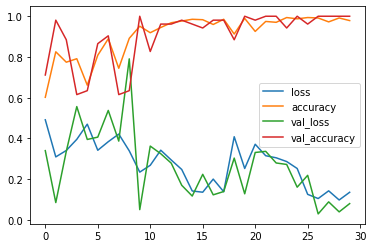

In [171]:
pd.DataFrame(siamese_history.history).plot()

In [172]:
pd.DataFrame(siamese_history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.491606,0.602128,0.340356,0.711538
1,0.309594,0.825532,0.085443,0.980769
2,0.341123,0.774468,0.336881,0.884615
3,0.395669,0.791489,0.556587,0.615385
4,0.470180,0.661702,0.395180,0.634615
5,0.342152,0.808511,0.406642,0.865385
6,0.384185,0.889362,0.537680,0.903846
7,0.421682,0.744681,0.387094,0.615385
8,0.339313,0.891489,0.790842,0.634615
9,0.234848,0.951064,0.050847,1.000000


In [173]:
siamese_model.evaluate(test_data)

2/2 [==============================] - 1s 107ms/step - loss: 0.0650 - accuracy: 1.0000


[0.06498409062623978, 1.0]

In [174]:
plt.imshow

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=<deprecated parameter>, filternorm=1, filterrad=4.0, imlim=<deprecated parameter>, resample=None, url=None, *, data=None, **kwargs)>

In [ ]:
# Save weights
siamese_model.save('siamesemodel')

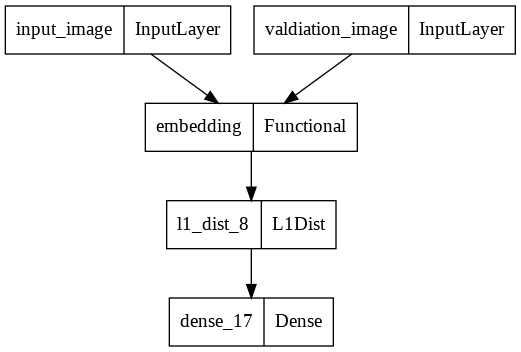

In [175]:
tf.keras.utils.plot_model(siamese_model)